# Optimization example using PolynomialFeatures

In [23]:
import os
from polynomialfeatures import rsmprofiler as rsm
from polynomialfeatures import desirability as dsr
from polynomialfeatures import rsmoptimize as ropt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
def grid_plotter(x, y, df, group = None, plot_title = None, y_label = 'Desirability', x_scale = 'linear', y_scale = 'linear', share_y = True, share_x = False,figsize = None):
    
    nrows = 1
    ncols = len(x)
    
    df_max = df_opt.iloc[df_opt['D'].idxmax()]
    
    if figsize is None:
        figsize = [4*ncols,4*nrows]
    
    fig, axs = plt.subplots(nrows,ncols, sharex = share_x, sharey = share_y, figsize = figsize)
    #fig.tight_layout()
    
    for idx,cl in enumerate(x):

        sns.scatterplot(x = cl, y = y, data = df, ax = axs[idx])
        
        axs[idx].axvline(df_max[cl],0,1, ls = '--', c = 'r')
        axs[idx].axhline(df_max[y],0,1, ls = '--', c = 'r')
        
        #axs[idx,jdx].set_title('{}={}, {}={}'.format(row,rw,col,cl))
        axs[idx].set_xscale(x_scale)
        axs[idx].set_yscale(y_scale)
        
        axs[idx].set_ylabel(y_label)
        
        axs[idx].set_ylim([0,1])
        
    fig.subplots_adjust(wspace=0.15, hspace=0.25)
    plt.suptitle(plot_title)
    return fig

List of csv files containing regression coefficients. Note only "Term" and "Estimate" columns are required.

In [25]:
# List of paths to regression coefficients
param_fp = [os.path.join(os.getcwd(),'estimates/coeff_A.csv'),
            os.path.join(os.getcwd(),'estimates/coeff_B.csv'),
           ]

df = pd.read_csv(param_fp[0])
df.head()

Term   Estimate  Std Error  t Ratio Prob>|t|
0  Intercept  71.679747   1.674168    42.82   <.0001
1        SCF   9.913870   1.857172     5.34   <.0001
2       IL-3  15.841512   1.857172     8.53   <.0001
3       TNFa  32.033221   1.857172    17.25   <.0001
4   SCF*TNFa   7.191631   2.157839     3.33   0.0017

Create a `MultiRSM` object that contains the regression models built from the coefficients above.

In [26]:
factors = ['SCF','Flt3L','IL-3','IL-7','TNFa','CXCL12'] # Names of factors, spelling must match .csv files
names = ['A','B'] # Name assigned to each model
factor_base = 2   # For converting scaled to actual factor values X_real = factor_constant * factor_base ^ X_scaled. Single value or list with len(factors)
factor_constant = [1,1,1,1,1,1] # Single value or list with len(factors)

In [27]:
multiprofiler = rsm.MultiRSM(factors = factors,
                             params = param_fp,
                             factor_base = factor_base,
                             factor_constant = factor_constant,
                             names = names
                             )
# Approximate min and max response
ymin, ymax = multiprofiler.estimate_range(factor_range = [-2.366,2.366])

# The are application specific and needed to create desirability functions
ymin = (-np.ones(ymin.shape)).tolist()
ymax = (1.5*ymax).tolist()

Create the desirability objective using `OverallDesirability` and use it to create the optimizer with `OptObjects`.

In [28]:
# Create objectives
desire = dsr.OverallDesirability(objective = ['max','max'],
                                 y_lower = ymin,
                                 y_upper = ymax,
                                 y_target = None)
# Create optimizer
optimizer = ropt.OptObjects(multiprofiler, desire, clip_min = None, clip_max = None, clip_norm = 2.366)

Run the Basinhopping algorithm

In [29]:
n_starts = 25
maxiter = 250
# Call the basinhopping algorithm
X,D = ropt.basinhopping(optimizer, n_starts = n_starts, maxiter = maxiter, method = 'nelder-mead', x_norm = 2.366, verbose = False)

In [30]:
# Put optimization results in df
df_opt = pd.DataFrame(multiprofiler.inverse_scale_factors(X), columns = factors)
df_opt['D'] = D
df_opt.head()

SCF     Flt3L      IL-3      IL-7      TNFa    CXCL12         D
0  2.100716  1.777927  1.479174  1.526676  2.939448  0.571716  0.750500
1  2.111796  0.495897  0.678213  2.127792  2.604924  1.035978  0.600338
2  0.695651  0.743349  1.773044  1.850432  2.176721  0.340896  0.563297
3  3.016836  1.873434  1.186574  0.370213  0.891482  1.240144  0.476994
4  1.442245  1.126719  2.643773  1.042746  3.523545  0.914342  0.832538

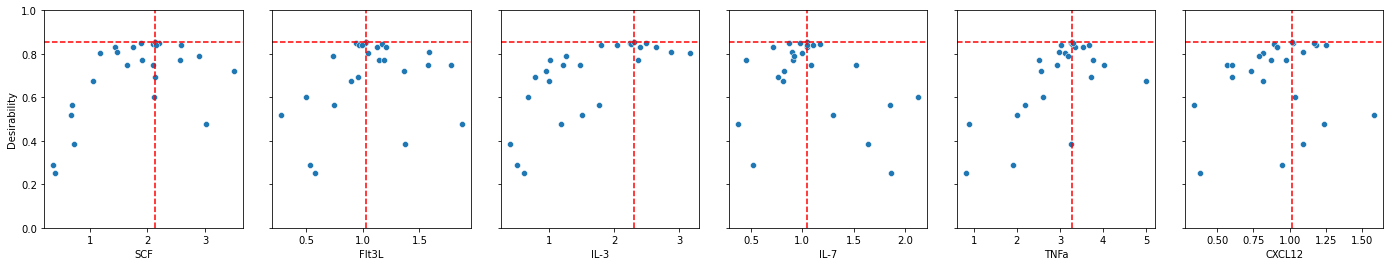

In [31]:
# Plot factor level by desirability
fig = grid_plotter(factors, 'D', df_opt, x_scale = 'linear')